In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold


In [125]:
# Load the data
df = pd.read_csv('week4/bank-full.csv', sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [103]:
# # Select the required columns
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 
           'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 
           'previous', 'poutcome', 'y']
df = df[columns]

# Encode target variable
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [94]:

# df = pd.read_csv('bank-full.csv', delimiter=';')
# columns_needed = [
#     'age', 'job', 'marital', 'education', 'balance', 
#     'housing', 'contact', 'day', 'month', 'duration', 
#     'campaign', 'pdays', 'previous', 'poutcome', 'y'
# ]
# df = df[columns_needed]


In [105]:
# Split into train (60%), validation (20%), and test (20%) sets
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)


In [106]:
## Question 1: ROC AUC Feature Importance

# Define the numerical columns
numerical = ['balance', 'day', 'duration', 'previous']
auc_scores = {}

# Calculate AUC for each numerical feature
for col in numerical:
    auc = roc_auc_score(df_train['y'], df_train[col])
    # If AUC is less than 0.5, invert the column
    if auc < 0.5:
        auc = roc_auc_score(df_train['y'], -df_train[col])
    auc_scores[col] = auc

# Find the numerical variable with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
best_feature, auc_scores[best_feature]
print(f"The feature with the highest AUC is: {best_feature}")

The feature with the highest AUC is: duration


In [107]:
## Question 2: Training the Model

# Prepare the training data for one-hot encoding
dv = DictVectorizer(sparse=False)
train_dict = df_train.drop(columns='y').to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# Prepare validation data
val_dict = df_val.drop(columns='y').to_dict(orient='records')
X_val = dv.transform(val_dict)

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train['y'])

# Predict probabilities for validation data
val_pred = model.predict_proba(X_val)[:, 1]

# Calculate AUC on the validation set
auc_val = roc_auc_score(df_val['y'], val_pred)
round(auc_val, 3)
print(f"Answer: {round(auc_val, 3)}")

Answer: 0.9


/home/bench/Documents/projects/ML-zoomcamp-Homework/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


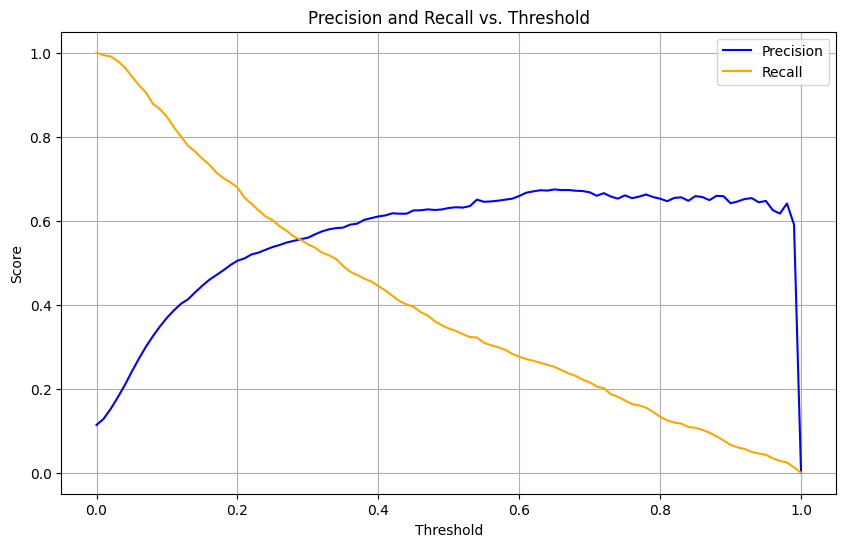

In [126]:
## Question 3: Precision and Recall
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Convert 'y' from string to binary integers
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(df_val['y'])

# Generate thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.01)
precision = []
recall = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    preds = (val_pred >= threshold).astype(int)
    precision.append(precision_score(y_true_encoded, preds))
    recall.append(recall_score(y_true_encoded, preds))

# Plot precision and recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision, label='Precision', color='blue')
plt.plot(thresholds, recall, label='Recall', color='orange')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()


In [127]:
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold for F1 score: {best_threshold}")


Optimal threshold for F1 score: 0.2


In [131]:
# Find where precision and recall intersect
intersection_idx = np.argmin(np.abs(np.array(precision) - np.array(recall)))
intersection_threshold = thresholds[intersection_idx]
intersection_threshold
print(f"Intersection Threshold: {intersection_threshold:.3f}")


Intersection Threshold: 1.000


In [132]:
## Question 4: F1 Score
f1_scores = []

# Compute F1 for each threshold
for threshold in thresholds:
    preds = (val_pred >= threshold).astype(int)
    f1_scores.append(f1_score(df_val['y'], preds))

# Find the threshold with the highest F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_threshold

print("Best threshold for maximum F1 score:", max_f1_threshold)

Best threshold for maximum F1 score: 0.2


In [119]:
### Question 5: 5-Fold Cross-Validation


# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kf.split(df_train):
    df_train_cv = df_train.iloc[train_idx]
    df_val_cv = df_train.iloc[val_idx]
    
    # Prepare data
    train_dict_cv = df_train_cv.drop(columns='y').to_dict(orient='records')
    X_train_cv = dv.fit_transform(train_dict_cv)
    val_dict_cv = df_val_cv.drop(columns='y').to_dict(orient='records')
    X_val_cv = dv.transform(val_dict_cv)
    
    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_cv, df_train_cv['y'])
    
    # Predict and calculate AUC
    val_pred_cv = model.predict_proba(X_val_cv)[:, 1]
    auc = roc_auc_score(df_val_cv['y'], val_pred_cv)
    scores.append(auc)

# Calculate the standard deviation of AUC scores
std_auc = np.std(scores)
round(std_auc, 4)

print("Best threshold for maximum F1 score:", round(std_auc, 4))


Best threshold for maximum F1 score: 0.0041


In [133]:
### Question 6: Hyperparameter Tuning

# Define C values to test
C_values = [0.000001, 0.001, 1]
mean_scores = {}
std_scores = {}

# Create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Iterate over different C values
for C in C_values:
    scores = []
    
    # Cross-validation loop
    for train_idx, val_idx in kf.split(df_train):
        df_train_cv = df_train.iloc[train_idx]
        df_val_cv = df_train.iloc[val_idx]
        
        # Prepare training and validation data for one-hot encoding
        train_dict_cv = df_train_cv.drop(columns='y').to_dict(orient='records')
        X_train_cv = dv.fit_transform(train_dict_cv)
        
        val_dict_cv = df_val_cv.drop(columns='y').to_dict(orient='records')
        X_val_cv = dv.transform(val_dict_cv)
        
        # Train the logistic regression model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_cv, df_train_cv['y'])
        
        # Predict probabilities for validation data
        val_pred_cv = model.predict_proba(X_val_cv)[:, 1]
        
        # Calculate AUC score and store it
        auc = roc_auc_score(df_val_cv['y'], val_pred_cv)
        scores.append(auc)
    
    # Calculate mean and std deviation of AUC scores for the current C value
    mean_scores[C] = round(np.mean(scores), 3)
    std_scores[C] = round(np.std(scores), 3)

# Find the best C with the highest mean score and, in case of ties, the lowest std
best_C = min(mean_scores, key=lambda x: (-mean_scores[x], std_scores[x]))
best_C, mean_scores[best_C], std_scores[best_C]

print(f"Best C: {best_C}, Mean AUC: {mean_scores[best_C]}, Std AUC: {std_scores[best_C]}")


Best C: 1, Mean AUC: 0.908, Std AUC: 0.004
